# CS7643: GPT2 From Scratch & Fine Tuning

# 0. Setup

### [Optional] Set up Google Drive Connection

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
import os

# TODO: Fill in the Google Drive path where you uploaded assignment1
# Example: If you create a Fall2023 folder and put all the files under A1 folder, then 'Fall2023/A1'
GOOGLE_DRIVE_PATH_POST_MYDRIVE = 'cs7643/project'
GOOGLE_DRIVE_PATH = os.path.join('/content', 'drive', 'MyDrive', GOOGLE_DRIVE_PATH_POST_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

In [3]:
import sys
import numpy as np
import math
sys.path.append(GOOGLE_DRIVE_PATH)

NameError: name 'GOOGLE_DRIVE_PATH' is not defined

In [4]:
sys.path

['C:\\ProgramData\\anaconda3\\python312.zip',
 'C:\\ProgramData\\anaconda3\\DLLs',
 'C:\\ProgramData\\anaconda3\\Lib',
 'C:\\ProgramData\\anaconda3',
 '',
 'C:\\Users\\Khanh Nguyen\\AppData\\Roaming\\Python\\Python312\\site-packages',
 'C:\\Users\\Khanh Nguyen\\AppData\\Roaming\\Python\\Python312\\site-packages\\win32',
 'C:\\Users\\Khanh Nguyen\\AppData\\Roaming\\Python\\Python312\\site-packages\\win32\\lib',
 'C:\\Users\\Khanh Nguyen\\AppData\\Roaming\\Python\\Python312\\site-packages\\Pythonwin',
 'C:\\ProgramData\\anaconda3\\Lib\\site-packages',
 'C:\\ProgramData\\anaconda3\\Lib\\site-packages\\win32',
 'C:\\ProgramData\\anaconda3\\Lib\\site-packages\\win32\\lib',
 'C:\\ProgramData\\anaconda3\\Lib\\site-packages\\Pythonwin']

In [5]:
# if running locally set GOOGLE PATH
import sys

if 'google.colab' in sys.modules:
    print(f'Running in google colab. Our path is `{GOOGLE_DRIVE_PATH}`')
else:
    GOOGLE_DRIVE_PATH = '.'
    print('Running locally.')

Running locally.


### Set up for local:

In [6]:
import os
import sys
import numpy as np
import math
import matplotlib.pyplot as plt

# Get current working directory (sms_classification)
current_dir = os.getcwd()
print(f"Current directory: {current_dir}")

# Get parent directory (the root directory containing 'model')
parent_dir = os.path.dirname(current_dir)
print(f"Parent directory: {parent_dir}")

# Add parent directory to Python path
sys.path.append(parent_dir)
print(f"Python path now includes: {sys.path}")

Current directory: G:\Grad\CS7643-DeepLearning\cs7643-project\sms_classification
Parent directory: G:\Grad\CS7643-DeepLearning\cs7643-project
Python path now includes: ['C:\\ProgramData\\anaconda3\\python312.zip', 'C:\\ProgramData\\anaconda3\\DLLs', 'C:\\ProgramData\\anaconda3\\Lib', 'C:\\ProgramData\\anaconda3', '', 'C:\\Users\\Khanh Nguyen\\AppData\\Roaming\\Python\\Python312\\site-packages', 'C:\\Users\\Khanh Nguyen\\AppData\\Roaming\\Python\\Python312\\site-packages\\win32', 'C:\\Users\\Khanh Nguyen\\AppData\\Roaming\\Python\\Python312\\site-packages\\win32\\lib', 'C:\\Users\\Khanh Nguyen\\AppData\\Roaming\\Python\\Python312\\site-packages\\Pythonwin', 'C:\\ProgramData\\anaconda3\\Lib\\site-packages', 'C:\\ProgramData\\anaconda3\\Lib\\site-packages\\win32', 'C:\\ProgramData\\anaconda3\\Lib\\site-packages\\win32\\lib', 'C:\\ProgramData\\anaconda3\\Lib\\site-packages\\Pythonwin', 'G:\\Grad\\CS7643-DeepLearning\\cs7643-project']


### Import Modules

In [7]:
!pip install tiktoken

In [8]:
from importlib.metadata import version
import tiktoken
print("tiktoken version:", version("tiktoken"))

tiktoken version: 0.9.0


In [9]:
import torch
print("torch version:", version("torch"))

device = 'mps' if torch.backends.mps.is_available() else ('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device = " + device)
if device == 'cpu':
    print("WARNING: Using CPU will cause slower train times")

torch version: 2.5.1
Using device = cuda


In [10]:
from torch.utils.data import Dataset, DataLoader

In [11]:
from torch import nn

In [12]:
import pandas as pd

In [13]:
import urllib
from pathlib import Path
import time
from tqdm import tqdm

# 1. Implement a GPT-2 Model

In [14]:
from model.gpt import GPTModel, text_to_token_ids, token_ids_to_text, generate_text_simple, generate, print_model_stats, TransformerBlock
from model.load_model import load_weights
from model.lora_gpt import LoRALayer, LinearWithLoRA, replace_linear_with_lora, replace_linear_with_lora_last_n

## 1.0 Utils

In [15]:
from transformers import GPT2Model

# Available Models Names
model_names = {
    "gpt2-small (124M)": "openai-community/gpt2",
    "gpt2-medium (355M)": "openai-community/gpt2-medium",
    "gpt2-large (774M)": "openai-community/gpt2-large",
    "gpt2-xl (1558M)": "openai-community/gpt2-xl"
}

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

def get_raw_gpt(model_name):
    if model_name not in model_configs:
        raise ValueError(f"Unknown model name: {model_name}")

    base_config_copy = BASE_CONFIG.copy()
    base_config_copy.update(model_configs[model_name])
    return GPTModel(base_config_copy)

def get_pretrained_gpt_model(model_name, verbose=True):
    if model_name not in model_configs:
        raise ValueError(f"Unknown model name: {model_name}")

    base_config_copy = BASE_CONFIG.copy()
    base_config_copy.update(model_configs[model_name])
    gpt_model = GPTModel(base_config_copy)

    hf_pretrained_gpt = GPT2Model.from_pretrained(model_names[model_name], cache_dir="checkpoints")
    load_weights(gpt_model, hf_pretrained_gpt, base_config_copy)

    if verbose:
        print_model_stats(gpt_model, model_name)

    return gpt_model

In [16]:
def convert_to_lora_model(model: GPTModel, rank: int, alpha: int, last_n_trf_blocks=None) -> GPTModel:
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total trainable parameters before: {total_params:,}")

    for param in model.parameters():
        param.requires_grad = False

    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total trainable parameters after: {total_params:,}")

    if last_n_trf_blocks is not None:
        replace_linear_with_lora_last_n(model, n=last_n_trf_blocks, rank=rank, alpha=alpha)
    else:
        replace_linear_with_lora(model, rank=rank, alpha=alpha)

    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total trainable LoRA parameters: {total_params:,}")
    model.to(device)
    return model

## 1.1 Sanity Check Creating GPT Model

In [17]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "emb_dim": 768,          # Embedding dimension
    "n_heads": 12,           # Number of attention heads
    "n_layers": 12,          # Number of layers
    "drop_rate": 0.1,        # Dropout rate
    "qkv_bias": False        # Query-Key-Value bias
}

torch.manual_seed(123)
test_raw_gpt = GPTModel(GPT_CONFIG_124M)
test_raw_gpt.eval()  # disable dropout

start_context = "Hello, I am"

tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))
encoded_tensor = text_to_token_ids(start_context, tokenizer)

print(f"\n{50*'='}\n{22*' '}IN\n{50*'='}")
print("\nInput text:", start_context)
print("Encoded input text:", encoded_tensor)
print("encoded_tensor.shape:", encoded_tensor.shape)

out_token_ids = generate_text_simple(
    model=test_raw_gpt,
    token_ids=encoded_tensor,
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)
decoded_text = token_ids_to_text(out_token_ids, tokenizer)

print(f"\n\n{50*'='}\n{22*' '}OUT\n{50*'='}")
print("\nOutput:", out_token_ids)
print("Output length:", len(out_token_ids[0]))
print("Output text:", decoded_text)

[50256]

                      IN

Input text: Hello, I am
Encoded input text: tensor([[15496,    11,   314,   716]])
encoded_tensor.shape: torch.Size([1, 4])


                      OUT

Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267,
         49706, 43231, 47062, 34657]])
Output length: 14
Output text: Hello, I am Featureiman Byeswickattribute argue logger Normandy Compton analogous


In [18]:
total_params = sum(p.numel() for p in test_raw_gpt.parameters())
print(f"Total Parameters: {total_params:,}")

total_params_gpt2 =  total_params - sum(p.numel() for p in test_raw_gpt.out_head.parameters())
print(f"Number of trainable parameters considering weight tying: {total_params_gpt2:,}")

Total Parameters: 163,009,536
Number of trainable parameters considering weight tying: 124,412,160


In [19]:
print_model_stats(test_raw_gpt, "GPT-124M")

Model Name: GPT-124M
	Total Parameters: 163,009,536
	Total Memory Requirement: 621.83 MB


## 1.2 Sanity Check Loading Pre-trained Weights

In [20]:
# CHOOSE_MODEL = "gpt2-medium (355M)"
CHOOSE_MODEL = "gpt2-large (774M)"
test_pretrained_gpt = get_pretrained_gpt_model(CHOOSE_MODEL, verbose=False)

In [21]:
torch.manual_seed(123)

tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=test_pretrained_gpt.to(device),
    # token_ids=text_to_token_ids("Every effort moves", tokenizer).to(device),
    token_ids=text_to_token_ids("The state capital of New Jersey is Newark. The state capital of California is", tokenizer).to(device),
    max_new_tokens=30,
    context_size=BASE_CONFIG["context_length"],
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 The state capital of New Jersey is Newark. The state capital of California is Los Angeles. The state capital of New York is Albany. The state capital of Texas is Austin. The state capital of Florida is Miami. The state


## 1.3 Sanity check LoRA model

In [22]:
test_lora_gpt = get_pretrained_gpt_model("gpt2-small (124M)", verbose=False)

In [23]:
total_params = sum(p.numel() for p in test_lora_gpt.parameters() if p.requires_grad)
print(f"Total trainable parameters before: {total_params:,}")

for param in test_lora_gpt.parameters():
    param.requires_grad = False

total_params = sum(p.numel() for p in test_lora_gpt.parameters() if p.requires_grad)
print(f"Total trainable parameters after: {total_params:,}")

Total trainable parameters before: 163,037,184
Total trainable parameters after: 0


In [24]:
# replace_linear_with_lora(test_lora_gpt, rank=16, alpha=16)
replace_linear_with_lora_last_n(test_lora_gpt, n=2, rank=16, alpha=16)

total_params = sum(p.numel() for p in test_lora_gpt.parameters() if p.requires_grad)
print(f"Total trainable LoRA parameters: {total_params:,}")

Applying LoRA with rank=16, alpha=16 to the last 2 transformer blocks (indices 10 to 11).
Total trainable LoRA parameters: 1,258,768


In [25]:
torch.manual_seed(123)

tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=test_lora_gpt.to(device),
    token_ids=text_to_token_ids("Every effort moves", tokenizer).to(device),
    max_new_tokens=30,
    context_size=BASE_CONFIG["context_length"],
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves forward, but it's not enough.

"I'm not going to sit here and say, 'I'm not going to do this,'


# 3. The Verdict Dataset Loaders

In [26]:
class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]


def create_dataloader_v1(txt, batch_size=4, max_length=256,
                         stride=128, shuffle=True, drop_last=True, num_workers=0):
    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)

    return dataloader

In [27]:
class SpamDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=None, pad_token_id=50256):
        self.data = dataframe
        
        # Convert to string and check for NaN values
        self.data['Message'] = self.data['Message'].astype(str)
        
        # Pre-tokenize texts with error handling
        self.encoded_texts = []
        for i, text in enumerate(self.data["Message"]):
            try:
                encoded = tokenizer.encode(text)
                self.encoded_texts.append(encoded)
            except Exception as e:
                print(f"Error encoding text at index {i}: {text}")
                print(f"Error message: {str(e)}")
                # Use an empty sequence as fallback
                self.encoded_texts.append([])
        
        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
        
        # Truncate sequences if they are longer than max_length
        self.encoded_texts = [
            encoded_text[:self.max_length] if len(encoded_text) > 0 else [0]
            for encoded_text in self.encoded_texts
        ]

        # Pad sequences to the longest sequence
        self.encoded_texts = [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]

        # Convert labels to integers
        self.labels = [1 if label == "spam" else 0 for label in self.data["Label"]]

    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.labels[index]
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )

    def __len__(self):
        return len(self.data)

    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length

### Download data

In [28]:
import urllib.request
import zipfile
import os
from pathlib import Path

url = "https://raw.githubusercontent.com/MWiechmann/enron_spam_data/master/enron_spam_data.zip"

zip_path = "enron_spam_data.zip"
extracted_path = "enron_spam_data"
date_file_path = Path(extracted_path)/"enron_spam_data.csv"

# Download the zip file
print(f"Downloading file from {url}...")
urllib.request.urlretrieve(url, zip_path)

# Check if the download was successful
if os.path.exists(zip_path):
    print(f"Download successful. File saved to {zip_path}")
    
    # Create extraction directory if it doesn't exist
    if not os.path.exists(extracted_path):
        os.makedirs(extracted_path)
    
    # Extract the zip file
    print(f"Extracting to {extracted_path}...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_path)
    
    # Check if the CSV file was extracted
    if os.path.exists(date_file_path):
        print(f"Extraction successful. CSV file available at {date_file_path}")
    else:
        print("Extraction completed, but CSV file not found.")
else:
    print("Download failed.")

Download successful. File saved to enron_spam_data.zip
Extracting to enron_spam_data...
Extraction successful. CSV file available at enron_spam_data\enron_spam_data.csv


### Put the data into pandas dataframe:

In [33]:
# Load only the Spam/Ham and Message columns into a DataFrame
df = pd.read_csv(date_file_path, usecols=['Spam/Ham', 'Message'])
df = df.rename(columns={'Spam/Ham': 'Label'})

# Display the first few rows of the DataFrame
print("\nDataFrame loaded successfully. Sample data:")
print(df.head())


DataFrame loaded successfully. Sample data:
                                             Message Label
0                                                NaN   ham
1  gary , production from the high island larger ...   ham
2             - calpine daily gas nomination 1 . doc   ham
3  fyi - see note below - already done .\nstella\...   ham
4  fyi .\n- - - - - - - - - - - - - - - - - - - -...   ham


In [34]:
print(df["Label"].value_counts())

Label
spam    17171
ham     16545
Name: count, dtype: int64


### Take 1000 samples for each label

In [48]:
def create_sample_dataset(df):
    # Sample 1000 instances from each class
    spam_subset = df[df["Label"] == "spam"].sample(500, random_state=123)
    ham_subset = df[df["Label"] == "ham"].sample(500, random_state=123)
    
    # Combine both subsets
    sample_df = pd.concat([ham_subset, spam_subset])
    
    # Shuffle the dataset
    sample_df = sample_df.sample(frac=1, random_state=123).reset_index(drop=True)
    
    return sample_df
    
sample_df = create_sample_dataset(df)
print(sample_df["Label"].value_counts())

Label
ham     500
spam    500
Name: count, dtype: int64


# 4. Training Loop

In [49]:
from sms_classification.train import calc_batch_loss, calc_loader_loss, evaluate_model, generate_and_print_sample, TrainingConfig, TrainingResults, train_model_simple, train_model
from sms_classification.train_plots import plot_losses, plot_perplexity, plot_and_save_learning_rate
import json


In [50]:
def save_training_results(results: TrainingResults, filename: str):
    results_dict = {
        "train_losses": results.train_losses,
        "val_losses": results.val_losses,
        "track_steps_seen": results.track_tokens_seen,
        "train_accuracies": results.train_accuracies,
        "val_accuracies": results.val_accuracies,
    }
    if results.track_lrs is not None:
        results_dict["track_lrs"] = results.track_lrs

    with open(filename, "w") as f:
        json.dump(results_dict, f, indent=4)
        print(f"Training results saved to {filename}")

## 4.2 Simple Train loop

In [57]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();  # Disable dropout during inference

In [58]:
print(sample_df[:99])

                                              Message Label
0   business highlights\nenron freight markets\nen...   ham
1   hey , i thought you might like to take a look ...  spam
2   http : / / www . virtu\nally - anywhere . com ...  spam
3   fyi\n- - - - - - - - - - - - - - - - - - - - -...   ham
4   to : yyyy @ netnoteinc . com\n# #\n# adult onl...  spam
..                                                ...   ...
94  the assembly will attempt to pass its version ...   ham
95  we all know prescriptions are less expensive i...  spam
96  mobile production units for developing countri...  spam
97  everyone should be using enron net works llc i...   ham
98  discount rx is simple , quick , and affordable...  spam

[99 rows x 2 columns]


In [59]:
# Train/validation ratio
from torch.utils.data import random_split

MAX_LENGTH = GPT_CONFIG_124M["context_length"]

sample_df = sample_df.sample(frac=1, random_state=42).reset_index(drop=True)
train_size = int(0.8 * len(sample_df))
val_size = len(sample_df) - train_size

dataset = SpamDataset(
    dataframe=sample_df,
    tokenizer=tokenizer,
    max_length=MAX_LENGTH
)
print(dataset)

# Split the dataset
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
print(f"Training samples: {len(train_dataset)}")
print(train_dataset)
print(f"Validation samples: {len(val_dataset)}")
print(val_dataset)

Training samples: 800
Validation samples: 200


In [60]:
torch.manual_seed(123)

num_workers = 0
batch_size = 8

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

print(train_loader)
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

In [62]:
print("Train loader:")
for input_batch, target_batch in train_loader:
    pass

print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions", target_batch.shape)

Train loader:
Input batch dimensions: torch.Size([8, 256])
Label batch dimensions torch.Size([8])


In [63]:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")

100 training batches
25 validation batches


### 4.2.1 Sanity check the simple training loop

In [64]:
import time

start_time = time.time()

torch.manual_seed(123)

model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 2
training_config = TrainingConfig(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    eval_freq=20,
    eval_iter=5,
    tokenizer=tokenizer,
)

sanity_check_training_results = train_model_simple(training_config)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 7.154, Val loss 7.080
Ep 1 (Step 000020): Train loss 0.976, Val loss 0.949
Ep 1 (Step 000040): Train loss 0.847, Val loss 1.043
Ep 1 (Step 000060): Train loss 0.686, Val loss 0.737
Ep 1 (Step 000080): Train loss 0.649, Val loss 0.718
Training accuracy: 42.50% | Validation accuracy: 50.00%
Ep 2 (Step 000100): Train loss 0.589, Val loss 0.690
Ep 2 (Step 000120): Train loss 0.505, Val loss 0.644
Ep 2 (Step 000140): Train loss 0.570, Val loss 0.567
Ep 2 (Step 000160): Train loss 0.593, Val loss 0.491
Ep 2 (Step 000180): Train loss 0.624, Val loss 0.603
Training accuracy: 72.50% | Validation accuracy: 65.00%
Training completed in 9.72 minutes.


In [65]:
import matplotlib.pyplot as plt

def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(6, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    # Create a second x-axis for examples seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(examples_seen, train_values, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig(f"{label}-plot.pdf")
    plt.show()


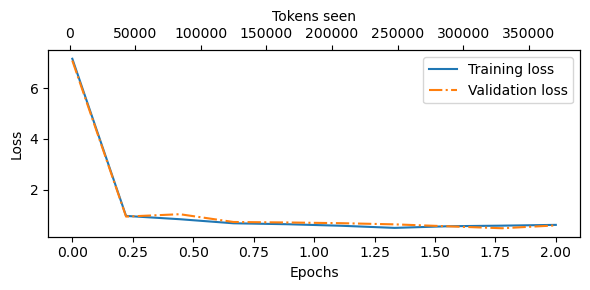

In [66]:
epochs_tensor = torch.linspace(0, num_epochs, len(sanity_check_training_results.train_losses))
plot_values(epochs_tensor,
            sanity_check_training_results.track_tokens_seen,
            sanity_check_training_results.train_losses,
            sanity_check_training_results.val_losses)

## 4.3 Advanced Train Loop

This training loop adds the following to the simple one:

1) Learning rate warmup

2) Cosine decay (after pear l.r has been reached)

3) Gradient clipping

### 4.3.1 Sanity check the advanced training loop

Typically, the number of warmup steps is between 0.1% to 20% of the total number of steps

In [67]:
num_epochs = 1
print(len(train_loader))
total_steps = len(train_loader) * num_epochs
warmup_steps = int(0.2 * total_steps) # 20% warmup
print(total_steps, warmup_steps)

100
100 20


In [68]:
start_time = time.time()

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)

peak_lr = 0.001
optimizer = torch.optim.AdamW(model.parameters(), lr=peak_lr, weight_decay=0.1)
tokenizer = tiktoken.get_encoding("gpt2")

num_epochs = 2
total_training_steps = len(train_loader) * num_epochs
print(f"Total number of training steps: {total_training_steps}")

training_config = TrainingConfig(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    eval_freq=20,
    eval_iter=5,
    tokenizer=tokenizer,
    warmup_steps=warmup_steps,
    initial_lr=1e-5,
    min_lr=1e-5,
)

sanity_check_advanced_training_results = train_model(training_config)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Total number of training steps: 200
Ep 1 (Iter 000000): Train loss 10.157, Val loss 10.012
Ep 1 (Iter 000020): Train loss 1.165, Val loss 1.075
Ep 1 (Iter 000040): Train loss 1.958, Val loss 2.606
Ep 1 (Iter 000060): Train loss 0.698, Val loss 0.712
Ep 1 (Iter 000080): Train loss 0.779, Val loss 0.713
Training accuracy: 37.50% | Validation accuracy: 50.00%
Ep 2 (Iter 000100): Train loss 0.667, Val loss 0.721
Ep 2 (Iter 000120): Train loss 0.644, Val loss 0.663
Ep 2 (Iter 000140): Train loss 0.617, Val loss 0.613
Ep 2 (Iter 000160): Train loss 0.562, Val loss 0.557
Ep 2 (Iter 000180): Train loss 0.533, Val loss 0.562
Training accuracy: 82.50% | Validation accuracy: 75.00%
Training completed in 13.29 minutes.


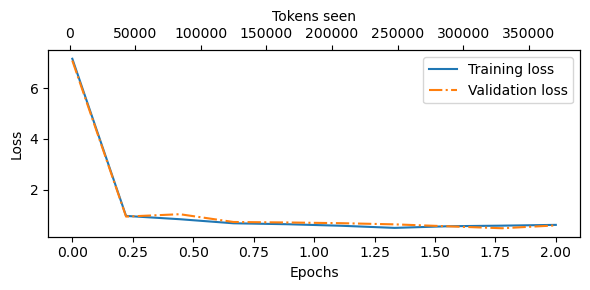

In [69]:
epochs_tensor = torch.linspace(0, num_epochs, len(sanity_check_training_results.train_losses))
plot_values(epochs_tensor,
            sanity_check_training_results.track_tokens_seen,
            sanity_check_training_results.train_losses,
            sanity_check_training_results.val_losses)

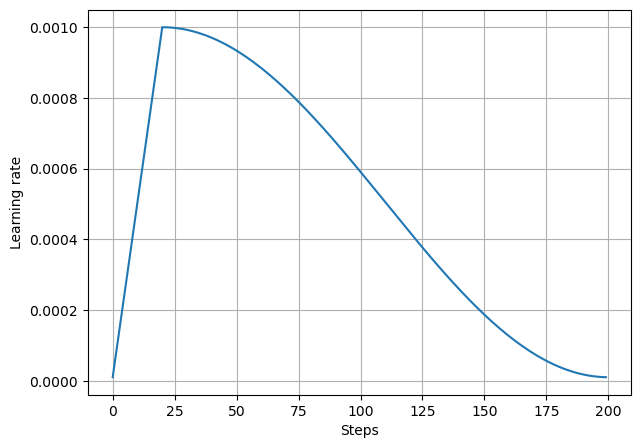

In [70]:
plt.figure(figsize=(7, 5))
plt.plot(range(len(sanity_check_advanced_training_results.track_lrs)), sanity_check_advanced_training_results.track_lrs)
plt.ylabel("Learning rate")
plt.xlabel("Steps")
plt.grid()
plt.show()

# 5. SMS Classification Fine Tuning

## 5.0 Utils

In [100]:
def print_model_losses(model, train_loader, val_loader, device):
    with torch.no_grad():
        train_loss = calc_loader_loss(train_loader, model, device, num_batches=5)
        val_loss = calc_loader_loss(val_loader, model, device, num_batches=5)

    print("Training loss:", train_loss)
    print("Validation loss:", val_loss)
    print("Training perplexity:", torch.exp(torch.tensor(train_loss)).item())
    print("Validation perplexity:", torch.exp(torch.tensor(val_loss)).item())

def print_classification_metrics(model, train_loader, val_loader, device):
    model.eval() # Ensure model is in evaluation mode
    with torch.no_grad():
        # Calculate Loss (using updated classification loss function)
        train_loss = calc_loader_loss(train_loader, model, device, num_batches=len(train_loader)) # Use full loader for better estimate
        val_loss = calc_loader_loss(val_loader, model, device, num_batches=len(val_loader))
        # Calculate Accuracy (using updated classification accuracy function)
        train_acc = calc_loader_accuracy(train_loader, model, device, num_batches=len(train_loader))
        val_acc = calc_loader_accuracy(val_loader, model, device, num_batches=len(val_loader))
    model.train() # Set back to train mode

    print(f"Training loss: {train_loss:.4f}")
    print(f"Validation loss: {val_loss:.4f}")
    print(f"Training accuracy: {train_acc:.4f}") # Print accuracy
    print(f"Validation accuracy: {val_acc:.4f}") # Print accuracy

In [101]:
import json

def download_and_load_json_file(file_path, url):
    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)

    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)

    return data

In [102]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

def format_response(entry):
    return f"\n\n### Response:\n{entry['output']}"

In [103]:
def load_json_data(filepath):
    with open(filepath, 'r') as f:
        data = json.load(f)
    return data

In [104]:
def generate_model_response(model, test_data, file_path=None):
    model.eval()
    with torch.no_grad():
        for i, entry in tqdm(enumerate(test_data), total=len(test_data)):
            instruction_text = format_input(entry)
            token_ids = generate(
                model=model.to(device),
                token_ids=text_to_token_ids(instruction_text, tokenizer).to(device),
                max_new_tokens=512,
                context_size=BASE_CONFIG["context_length"],
                eos_id=50256,
            )
            generated_text = token_ids_to_text(token_ids, tokenizer)

            response_text = generated_text[len(instruction_text):].replace("### Response:", "").strip()
            entry["generated_text"] = response_text

    # Save the data
    if file_path:
        with open(file_path, 'w') as f:
            json.dump(test_data, f, indent=4)

    return test_data

In [105]:
def print_model_losses(model, train_loader, val_loader, device):
    with torch.no_grad():
        train_loss = calc_loader_loss(train_loader, model, device, num_batches=5)
        val_loss = calc_loader_loss(val_loader, model, device, num_batches=5)

    print("Training loss:", train_loss)
    print("Validation loss:", val_loss)
    print("Training perplexity:", torch.exp(torch.tensor(train_loss)).item())
    print("Validation perplexity:", torch.exp(torch.tensor(val_loss)).item())
    print()

## 5.2 Organizing data into training batches

In [ ]:
class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data

        # Pre-tokenize texts
        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = format_response(entry)
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)

In [ ]:
def custom_collate_fn(
    batch,
    pad_token_id=50256,
    ignore_index=-100,
    allowed_max_length=None,
    device="cpu"
):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs and targets
    inputs_lst, targets_lst = [], []

    for item in batch:          # item is just list of token ids e.g. [0, 1, 2, 3]
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])  # Truncate the last token for inputs
        targets = torch.tensor(padded[1:])  # Shift +1 to the right for targets

        # New: Replace all but the first padding tokens in targets by ignore_index
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index

        # New: Optionally truncate to maximum sequence length
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # Convert list of inputs and targets to tensors and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)

    return inputs_tensor, targets_tensor

In [ ]:
from functools import partial

customized_collate_fn = partial(
    custom_collate_fn,
    device=device,
    allowed_max_length=1024
)

## 5.1 Prepare Dataset

In [ ]:
file_path = "instruction-data.json"
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/01_main-chapter-code/instruction-data.json"
)

data = download_and_load_json_file(file_path, url)
print("Number of entries:", len(data))

In [ ]:
print("Example entry:\n", data[50])

In [ ]:
def save_first_n_entries(data, n, filename):
    """Saves the first n entries of the data to a JSON file."""
    try:
        with open(filename, 'w') as f:
            json.dump(data[:n], f, indent=4)  # Use indent for pretty printing
        print(f"Successfully saved the first {n} entries to {filename}")
    except Exception as e:
        print(f"An error occurred: {e}")

save_first_n_entries(
    data, 30,
    GOOGLE_DRIVE_PATH + "/instr_fine_tune" + "/data/alpaca_sample_generation_data_30.json")

In [ ]:
print(format_input(data[50]) + format_response(data[50]))

In [ ]:
train_portion = int(len(data) * 0.85)  # 85% for training
test_portion = int(len(data) * 0.1)    # 10% for testing
val_portion = len(data) - train_portion - test_portion  # Remaining 5% for validation

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

In [ ]:
print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

## 5.3 Creating data loaders for an instruction dataset

In [ ]:
tokenizer = tiktoken.get_encoding("gpt2")

In [ ]:
num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

In [ ]:
print("Train loader:")
i = 0
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)
    if i == 3: break
    i += 1

## 5.4 Loading a pretrained LLM

In [ ]:
CHOOSE_MODEL = "gpt2-medium (355M)"
gpt_m = get_pretrained_gpt_model(CHOOSE_MODEL)

In [ ]:
input_text = format_input(val_data[0])
print(input_text)

In [ ]:
torch.manual_seed(123)

tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=gpt_m.to(device),
    token_ids=text_to_token_ids(input_text, tokenizer).to(device),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
)

generated_text = token_ids_to_text(token_ids, tokenizer)
print("Output text:\n", generated_text)

In [ ]:
response_text = (
    generated_text[len(input_text):]
    .replace("### Response:", "")
    .strip()
)
print(response_text)

## 5.5 Finetuning the LLM on instruction data

Initial Loss

In [ ]:
torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loader_loss(train_loader, gpt_m, device, num_batches=5)
    val_loss = calc_loader_loss(val_loader, gpt_m, device, num_batches=5)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)
print("Training perplexity:", torch.exp(torch.tensor(train_loss)).item())
print("Validation perplexity:", torch.exp(torch.tensor(val_loss)).item())

In [ ]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(gpt_m.parameters(), lr=0.00005, weight_decay=0.1)
num_epochs = 2

ift_mini_alpaca_training_config = TrainingConfig(
    model=gpt_m,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    eval_freq=5,
    eval_iter=5,
    start_context=format_input(val_data[0]),
    tokenizer=tokenizer,
)

ift_mini_alpaca_training_results = train_model_simple(ift_mini_alpaca_training_config)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

In [ ]:
epochs_tensor = torch.linspace(
    0, num_epochs, len(ift_mini_alpaca_training_results.train_losses))

plot_losses(epochs_tensor,
            ift_mini_alpaca_training_results.track_tokens_seen,
            ift_mini_alpaca_training_results.train_losses,
            ift_mini_alpaca_training_results.val_losses)

In [ ]:
token_ids = generate(
    model=gpt_m.to(device),
    token_ids=text_to_token_ids(input_text, tokenizer).to(device),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256,
)

generated_text = token_ids_to_text(token_ids, tokenizer)
print("Output text:\n", generated_text)

# 6. Alpaca Instruction Fine Tuning

## 6.0 [Optional] Download the ALpaca Dataset

In [ ]:
alpaca_data_url = "https://raw.githubusercontent.com/tatsu-lab/stanford_alpaca/main/alpaca_data.json"
file_path = GOOGLE_DRIVE_PATH + "/instr_fine_tune" + "/data/alpaca_data.json"

In [ ]:
alpaca_data = download_and_load_json_file(file_path, alpaca_data_url)
print("Number of entries:", len(alpaca_data))

We will select only 12K entries of the 52K for compute reasons.

We will only keep entires whose output is less than 512 characters in length

In [ ]:
def filter_alpaca_data_by_len(alpaca_data, target_size=12000, max_output_len=512, filepath=None):
    filtered_alpaca_data = []

    for entry in alpaca_data:
            if len(entry['output']) < max_output_len:
                filtered_alpaca_data.append(entry)
            if len(filtered_alpaca_data) >= target_size:
                break

    if filepath:
        with open(filepath, 'w') as f:
            json.dump(filtered_alpaca_data, f, indent=4)

    return filtered_alpaca_data

In [ ]:
alpaca_data_15k = filter_alpaca_data_by_len(
    alpaca_data, target_size=15000, max_output_len=512,
    filepath=GOOGLE_DRIVE_PATH + "/instr_fine_tune" + "/data/alpaca_data_15k.json")

In [ ]:
print("Number of entries:", len(alpaca_data_15k))

## Gemini Eval

In [ ]:
from google import genai
from google.genai import types
from google.colab import userdata


def gemini_generate(prompt):
    client = genai.Client(
        api_key=userdata.get('GOOGLE_API_KEY')
    )

    # model = "gemini-2.5-pro-exp-03-25"
    model = "gemini-2.0-flash-thinking-exp-01-21"
    contents = [
        types.Content(
            role="user",
            parts=[
                types.Part.from_text(text=prompt),
            ],
        ),
    ]
    generate_content_config = types.GenerateContentConfig(
        response_mime_type="text/plain",
    )

    for tries in range(3):
        try:
            response = client.models.generate_content(
                model=model,
                contents=contents,
                config=generate_content_config,
            )
            return response.text
        except Exception as e:
            print(f"An error occurred: {e}")
            time.sleep(30)
            continue

In [ ]:
gemini_generate("Hello, how are you?")

In [ ]:
def generate_model_scores(json_data, filepath=None):
    scores = []
    for entry in tqdm(json_data, desc="Scoring entries"):
        prompt = (
            f"Given the input `{format_input(entry)}` "
            f"and correct output `{entry['output']}`, "
            f"score the model response `{entry['generated_text']}`"
            f" on a scale from 0 to 100, where 100 is the best score. "
            f"Respond with the integer number only."
        )
        score = gemini_generate(prompt)
        try:
            scores.append(int(score))
            print(f"Score: {score}")
            entry["score"] = score
        except ValueError:
            print(f"Could not convert score: {score}")
            continue
        except Exception as e:
            print(f"An error occurred: {e}")
            time.sleep(5)
            continue

    if filepath:
        with open(filepath, 'w') as f:
            json.dump(json_data, f, indent=4)

    print(f"Mean score: {np.mean(scores)}")

    return scores

## 6.1 Prepare the Dataset

In [ ]:
alpaca_data_15k_filepath = GOOGLE_DRIVE_PATH + "/instr_fine_tune" + "/data/alpaca_data_15k.json"
alpaca_data_15k = load_json_data(alpaca_data_15k_filepath)

In [ ]:
alpaca_sample_generation_data_filepath = GOOGLE_DRIVE_PATH + "/instr_fine_tune" + "/data/alpaca_sample_generation_data_30.json"
alpaca_sample_generation_data = load_json_data(alpaca_sample_generation_data_filepath)

In [ ]:
num_entries = len(alpaca_data_15k)
print("Number of entries:", num_entries)

In [ ]:
train_portion = int(num_entries * 0.80)  # 85% for training
test_portion = int(num_entries * 0.10)    # 10% for testing
val_portion = num_entries - train_portion - test_portion  # Remaining 10% for validation

alpaca_train_data = alpaca_data_15k[:train_portion]
alpaca_test_data = alpaca_data_15k[train_portion:train_portion + test_portion]
alpaca_val_data = alpaca_data_15k[train_portion + test_portion:]

print("Training set length:", len(alpaca_train_data))
print("Validation set length:", len(alpaca_val_data))
print("Test set length:", len(alpaca_test_data))

In [ ]:
subset_alpaca_test_data = alpaca_sample_generation_data + alpaca_test_data[:20]
print("Subset of test data length:", len(subset_alpaca_test_data))

## 6.2 Create data loaders

In [ ]:
num_workers = 0
batch_size = 4

torch.manual_seed(123)
tokenizer = tiktoken.get_encoding("gpt2")

alpaca_train_dataset = InstructionDataset(alpaca_train_data, tokenizer)
alpaca_train_loader = DataLoader(
    alpaca_train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers,
)

alpaca_val_dataset = InstructionDataset(alpaca_val_data, tokenizer)
alpaca_val_loader = DataLoader(
    alpaca_val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
)

alpaca_test_dataset = InstructionDataset(alpaca_test_data, tokenizer)
alpaca_test_loader = DataLoader(
    alpaca_test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
)

In [ ]:
print("Train loader:")
i = 0
for inputs, targets in alpaca_train_loader:
    if i <= 3:
        print(inputs.shape, targets.shape)
    i += 1
print(f"There are {i} batches in the train loader")

## 6.3 Load Pretrained GPT2

In [ ]:
CHOOSE_MODEL = "gpt2-xl (1558M)"
# gpt2-large (774M)
pretrained_gpt_m = get_pretrained_gpt_model(CHOOSE_MODEL)

In [ ]:
generated_data_file_path = GOOGLE_DRIVE_PATH + "/instr_fine_tune" + "/data/runs/pretrained_gpt_xl_generated_data.json"
generated_data = generate_model_response(
    model=pretrained_gpt_m,
    test_data=subset_alpaca_test_data,
    file_path=generated_data_file_path
)
generated_data_scores = generate_model_scores(generated_data, generated_data_file_path)

In [ ]:
sample_text = format_input(alpaca_val_data[7])
print(sample_text)

In [ ]:
torch.manual_seed(123)

token_ids = generate_text_simple(
    model=pretrained_gpt_m.to(device),
    token_ids=text_to_token_ids(sample_text, tokenizer).to(device),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
)

generated_text = token_ids_to_text(token_ids, tokenizer)
print("Output text:\n", generated_text)

In [ ]:
response_text = (
    generated_text[len(sample_text):]
    .replace("### Response:", "")
    .strip()
)
print(response_text)

## 6.4 Finetune on Alpaca 12k

In [ ]:
def finetune_model(run_name):
    # 1) Initialize a Pre-trained GPT model
    CHOOSE_MODEL = "gpt2-medium (355M)"
    # CHOOSE_MODEL = "gpt2-large (774M)"
    pretrained_gpt_m = get_pretrained_gpt_model(CHOOSE_MODEL)
    pretrained_gpt_m.to(device)

    pretrained_gpt_m = convert_to_lora_model(pretrained_gpt_m, rank=16, alpha=16, last_n_trf_blocks=22)
    print_model_losses(pretrained_gpt_m, alpaca_train_loader, alpaca_val_loader, device)

    # 2) Finetune the model
    start_time = time.time()
    torch.manual_seed(123)

    optimizer = torch.optim.AdamW(pretrained_gpt_m.parameters(), lr=5e-5, weight_decay=0.1)
    num_epochs = 2
    total_steps = len(alpaca_train_loader) * num_epochs
    warmup_steps = int(0.2 * total_steps) # 20% warmup

    ift_alpaca_training_config = TrainingConfig(
        model=pretrained_gpt_m,
        train_loader=alpaca_train_loader,
        val_loader=alpaca_val_loader,
        optimizer=optimizer,
        device=device,
        num_epochs=num_epochs,
        eval_freq=25,
        eval_iter=5,
        start_context=format_input(alpaca_val_data[7]),
        tokenizer=tokenizer,
        warmup_steps=warmup_steps,
        initial_lr=1e-5,
        min_lr=1e-5,
        run_name=run_name,
    )
    # ift_alpaca_training_results = train_model_simple(ift_alpaca_training_config)
    ift_alpaca_training_results = train_model(ift_alpaca_training_config)

    end_time = time.time()
    execution_time_minutes = (end_time - start_time) / 60
    print(f"Training completed in {execution_time_minutes:.2f} minutes.")

    # 3) Saving and logging
    directory_path = f"{GOOGLE_DRIVE_PATH}/instr_fine_tune/data/runs/{run_name}/"
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)

    # 3a) Save GPT model
    # model_file_path = directory_path + "pretrained_gpt_m.pth"
    # torch.save(pretrained_gpt_m.state_dict(), model_file_path)

    # 3b) Save training results
    training_results_file_path = directory_path + "training_results.json"
    save_training_results(ift_alpaca_training_results, training_results_file_path)

    # 3c) Plot learning curves
    plot_losses(ift_alpaca_training_config, ift_alpaca_training_results, directory_path + "loss_curves.png")
    plot_perplexity(ift_alpaca_training_config, ift_alpaca_training_results, directory_path + "perplexity_curves.png")

    # 3d) Generate sample responses
    generated_data_file_path = directory_path + "generated_data.json"
    generated_data = generate_model_response(
        model=pretrained_gpt_m,
        test_data=subset_alpaca_test_data,
        file_path=generated_data_file_path
    )

    return generated_data, ift_alpaca_training_results, ift_alpaca_training_config

In [ ]:
run_name = "run33"
generated_data, ift_alpaca_training_results, ift_alpaca_training_config = finetune_model(run_name)

In [ ]:
directory_path = f"{GOOGLE_DRIVE_PATH}/instr_fine_tune/data/runs/{run_name}/"
generated_data_file_path = directory_path + "generated_data.json"
generated_data_file_path

In [ ]:
generated_data_scores = generate_model_scores(generated_data, generated_data_file_path)

In [ ]:
plot_and_save_learning_rate(ift_alpaca_training_results, filepath=directory_path + "learning_rate.png")

## Scratch Pad